In [42]:
import cv2
from ultralytics import YOLO
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt
import numpy as np

In [2]:
detector = YOLO("yolov8n.pt")
ocr = PaddleOCR(use_angle_cls=True, lang="en")

[2026/01/21 09:17:07] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\tejas/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\tejas/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_len

In [3]:
img = cv2.imread("172561841_pg1.png")
results = detector("172561841_pg1.png")


image 1/1 d:\CONVOLVO\AI2\SCRIPT-DETECTION\172561841_pg1.png: 640x448 1 book, 171.6ms
Speed: 23.0ms preprocess, 171.6ms inference, 12.1ms postprocess per image at shape (1, 3, 640, 448)


In [18]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([73.])
conf: tensor([0.3950])
data: tensor([[1.4368e+01, 0.0000e+00, 1.1880e+03, 1.6979e+03, 3.9500e-01, 7.3000e+01]])
id: None
is_track: False
orig_shape: (1704, 1188)
shape: torch.Size([1, 6])
xywh: tensor([[ 601.1840,  848.9476, 1173.6320, 1697.8953]])
xywhn: tensor([[0.5060, 0.4982, 0.9879, 0.9964]])
xyxy: tensor([[  14.3681,    0.0000, 1188.0000, 1697.8953]])
xyxyn: tensor([[0.0121, 0.0000, 1.0000, 0.9964]])

In [ ]:
output = []

for box in results[0].boxes:
    cls = int(box.cls[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])

    crop = img[y1:y2, x1:x2]
    plt.imshow(crop)
    plt.axis('off')
    plt.show()

    if cls == 1:  # stamp
        ocr_result = ocr.ocr(crop, cls=True)
        text = " ".join([line[1][0] for line in ocr_result[0]])
    else:
        text = None

    output.append({
        "type": "signature" if cls == 0 else "stamp",
        "bbox": [x1, y1, x2, y2],
        "text": text
    })

In [49]:
output = [{
    "type": "stamp",
    "bbox": [831, 1262, 1076, 1491]
},
{
    "type": "signature",
    "bbox": [887, 1420, 1004, 1464]
},
{
    "type": "signature",
    "bbox": [176, 488, 462, 516]
}]

In [44]:
np.array(output[0]["bbox"]).astype(int)

array([ 831, 1262, 1076, 1491])

In [52]:
for line in range(len(output)):
    x, y, w, h = np.array(output[line]["bbox"]).astype(int)
    print(x, y, w,h )
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)


831 1262 1076 1491
887 1420 1004 1464
176 488 462 516


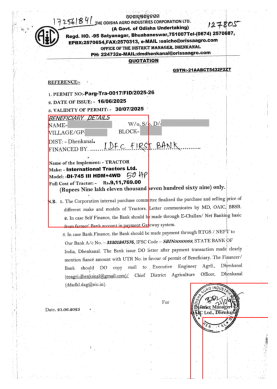

In [53]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
def draw_detections(img, detections):
    """
    detections = [
      {"type": "signature", "bbox": [x1, y1, x2, y2]},
      {"type": "stamp", "bbox": [x1, y1, x2, y2]}
    ]
    """
    vis = img.copy()

    for det in detections:
        x1, y1, x2, y2 = det["bbox"]
        label = det["type"]

        color = (0, 255, 0) if label == "signature" else (255, 0, 0)

        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            vis,
            label.upper(),
            (x1, y1 - 8),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
            cv2.LINE_AA
        )

    return vis


In [24]:
detections = []
for box in results[0].boxes:
    cls = int(box.cls[0])
    x1, y1, x2, y2 = map(int, box.xyxy[0])

    detections.append({
        "type": "signature" if cls == 0 else "stamp",
        "bbox": [x1, y1, x2, y2]
    })

vis_img = draw_detections(img, detections)

cv2.imwrite("detected_output.jpg", vis_img)

cv2.imshow("Detected Signatures & Stamps", vis_img)
cv2.waitKey(0)
cv2.destroyAllWindows()